Goal:
  * Develop "geozones" within Fairland Fire Department's primary response area and their corresponding "run strings." A geozone is a polygon in coordinates that relate it to geography, either GPS or UTM coordinates. A run string is the list of apparatus (potentially from multiple fire stations/departments) that should be initially dispatched to an incident at a given location.

Givens:
  * Area of interest is everything in Brandywine and Sugar Creek townships in Shelby County, Indiana
  * A list of apparatus by station and type
  * A list of station GPS coordinates

Assumptions:
  * Only considering fire incidents (for now); desired initial response is Fairland's apparatus plus closest non-Fairland engine plus closest two non-Fairland tankers (not from the same station)
  * Road network in the area is sufficient to ignore any special drive time/distance considerations; just use "as the crow flies" distance to judge "closest"
  * Output of this analysis will be the input to a "clean-up" pass performed manually by individuals familiar with the area who can catch any edge cases

Secondary goals:
  * Develop a (very deep) ordered list of each apparatus type for each geozone
  * Develop a mental image of the relative distances and regions involved
  * Potentially produce printed maps of relevant 

Let's define our data. One list of nearby stations, with their names and locations. One list of apparatus with information about which station they run from and what type(s) of apparatus they are considered in our classification system.

...plus some getter functions to make the data useable when we need it.

In [77]:
import pandas as pd

_stations = pd.DataFrame([
  {"id":1,"name":"Fairland Station 621","lat":39.584494256624545,"lon":-85.8656116467432},
  {"id":2,"name":"Moral Township Station 681","lat":39.6387254,"lon":-85.9070139},
  {"id":3,"name":"Needham Station 81","lat":39.529953,"lon":-85.9709754},
  {"id":4,"name":"Marietta Station 671","lat":39.4406702,"lon":-85.8810707},
  {"id":5,"name":"Shelbyville Station 691","lat":39.5227097,"lon":-85.7786288},
  {"id":6,"name":"IFD Station 16","lat":39.6691316,"lon":-86.0065276},
  {"id":7,"name":"Needham Station 82","lat":39.6040567,"lon":-85.9990409},
  {"id":8,"name":"Fountaintown Station 612","lat":39.6937218,"lon":-85.779439},
  {"id":9,"name":"IFD Station 55","lat":39.6962247,"lon":-85.9795233},
  {"id":10,"name":"Morristown Station 651","lat":39.6760901,"lon":-85.7045637},
  {"id":11,"name":"Waldron Station 641","lat":39.4537326,"lon":-85.6662435},
  {"id":12,"name":"Flat Rock Station 631","lat":39.3641328,"lon":-85.8309059},
  {"id":13,"name":"Sugar Creek Township Station 45","lat":39.7338448,"lon":-85.9131422},
  {"id":14,"name":"Manilla Station 61","lat":39.5710743,"lon":-85.617652},
  {"id":15,"name":"Whiteland Station 71","lat":39.5484272,"lon":-86.0747433},
  {"id":16,"name":"Shelbyville Station 692","lat":39.51627,"lon":-85.7434899},
  {"id":17,"name":"Shelbyville Station 693","lat":39.5055857,"lon":-85.7945173},
  {"id":18,"name":"Franklin Station 23","lat":39.523629,"lon":-86.0737878},
  {"id":19,"name":"Greenwood Station 91","lat":39.6134433,"lon":-86.1040209},
  {"id":20,"name":"St Paul Station 41","lat":39.4282778,"lon":-85.6285885},
  {"id":21,"name":"Sugar Creek Township Station 42","lat":39.7762501,"lon":-85.896068},
  {"id":22,"name":"Greenwood Station 94","lat":39.625805791286666,"lon":-86.06305093068505},
  {"id":23,"name":"New Whiteland Station 11","lat":39.5577404582559,"lon":-86.09102800041359},
  {"id":24,"name":"Franklin Station 22","lat":39.482230271604614,"lon":-86.02353331575846},
])

_apparatus = pd.DataFrame([
  {"id":1,"name":"73-Fairland-E621","station_id":1,"types":"engine"},
  {"id":2,"name":"73-Fairland-R621","station_id":1,"types":"engine,rescue"},
  {"id":3,"name":"73-Moral-E681","station_id":2,"types":"engine"},
  {"id":4,"name":"73-Moral-E682","station_id":2,"types":"engine"},
  {"id":5,"name":"73-Shelbyville-E691","station_id":5,"types":"engine"},
  {"id":6,"name":"73-Morristown-E651","station_id":10,"types":"engine"},
  {"id":7,"name":"73-Morristown-E652","station_id":10,"types":"engine"},
  {"id":8,"name":"73-Waldron-E641","station_id":11,"types":"engine"},
  {"id":9,"name":"30-Sugar Creek-E445","station_id":13,"types":"engine"},
  {"id":10,"name":"73-Shelbyville-E693","station_id":17,"types":"engine"},
  {"id":11,"name":"41-Franklin-E23","station_id":18,"types":"engine"},
  {"id":12,"name":"16-St. Paul-E841","station_id":20,"types":"engine"},
  {"id":13,"name":"30-Sugar Creek-E442","station_id":21,"types":"engine"},
  {"id":14,"name":"41-Needham-PT81","station_id":3,"types":"engine,tanker"},
  {"id":15,"name":"41-Needham-E82","station_id":7,"types":"engine"},
  {"id":16,"name":"73-Marietta-E671","station_id":4,"types":"engine"},
  {"id":17,"name":"49-IFD-E16","station_id":6,"types":"engine"},
  {"id":18,"name":"41-Whiteland-E71","station_id":15,"types":"engine"},
  {"id":19,"name":"41-Greenwood-E94","station_id":22,"types":"engine"},
  {"id":20,"name":"41-New Whiteland-E11","station_id":23,"types":"engine"},
  {"id":21,"name":"41-Franklin-E22","station_id":24,"types":"engine"},
  {"id":22,"name":"73-Shelbyville-L692","station_id":16,"types":"ladder,rescue"},
  {"id":23,"name":"41-Franklin-L23","station_id":18,"types":"ladder"},
  {"id":24,"name":"41-Greenwood-L91","station_id":19,"types":"ladder"},
  {"id":25,"name":"30-Sugar Creek-L445","station_id":13,"types":"ladder"},
  {"id":26,"name":"49-IFD-L55","station_id":9,"types":"ladder"},
  {"id":27,"name":"73-Fairland-T622","station_id":1,"types":"tanker"},
  {"id":28,"name":"73-Fairland-T621","station_id":1,"types":"tanker"},
  {"id":29,"name":"73-Moral-T681","station_id":2,"types":"tanker"},
  {"id":31,"name":"41-Needham-T82","station_id":7,"types":"tanker"},
  {"id":32,"name":"73-Marietta-T671","station_id":4,"types":"tanker"},
  {"id":33,"name":"41-Whiteland-T71","station_id":15,"types":"tanker"},
  {"id":34,"name":"49-IFD-T16","station_id":6,"types":"tanker"},
  {"id":35,"name":"73-Fountaintown-T612","station_id":8,"types":"tanker"},
  {"id":36,"name":"73-Fountaintown-T613","station_id":8,"types":"tanker"},
  {"id":37,"name":"49-IFD-T55","station_id":9,"types":"tanker"},
  {"id":38,"name":"73-Morristown-T651","station_id":10,"types":"tanker"},
  {"id":39,"name":"73-Morristown-T652","station_id":10,"types":"tanker"},
  {"id":40,"name":"73-Waldron-T641","station_id":11,"types":"tanker"},
  {"id":41,"name":"30-Sugar Creek-T442","station_id":21,"types":"tanker"},
  {"id":42,"name":"73-Flatrock-T631","station_id":12,"types":"tanker"},
  {"id":43,"name":"73-Fountatintown-E612","station_id":8,"types":"engine"},
  {"id":44,"name":"73-Fountatintown-E613","station_id":8,"types":"engine"},
])

def get_station_locations():
  return list(zip(_stations.lat, _stations.lon))

def get_stations():
  return _stations.drop(columns=['id'])

def get_engines():
  return _apparatus[_apparatus['types'].str.contains("engine")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'}).reset_index(drop=True)

def get_tankers():
  return _apparatus[_apparatus['types'].str.contains("tanker")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'}).reset_index(drop=True)

def get_ladders():
  return _apparatus[_apparatus['types'].str.contains("ladder")].join(_stations.set_index('id'), on='station_id', lsuffix='_apparatus', rsuffix='_station')[['name_apparatus','lat','lon']].rename(columns={'name_apparatus':'name'}).reset_index(drop=True)


Eyeball test to see if the data and the getters work...

In [78]:
print(get_stations().head())
print(get_engines().head())

                         name        lat        lon
0        Fairland Station 621  39.584494 -85.865612
1  Moral Township Station 681  39.638725 -85.907014
2          Needham Station 81  39.529953 -85.970975
3        Marietta Station 671  39.440670 -85.881071
4     Shelbyville Station 691  39.522710 -85.778629
                  name        lat        lon
0     73-Fairland-E621  39.584494 -85.865612
1     73-Fairland-R621  39.584494 -85.865612
2        73-Moral-E681  39.638725 -85.907014
3        73-Moral-E682  39.638725 -85.907014
4  73-Shelbyville-E691  39.522710 -85.778629


Looks reasonable. Let's plot it...

<AxesSubplot:>

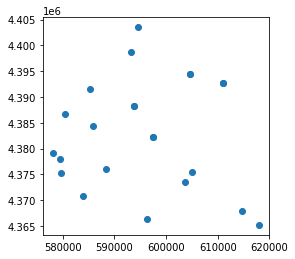

In [79]:
import geopandas as gpd

engines_df = get_engines()
engines = gpd.GeoDataFrame(engines_df, geometry=gpd.points_from_xy(engines_df.lon, engines_df.lat), crs='EPSG:4326')
engines = engines.to_crs('EPSG:26916')
engines.plot()

Uh...sure...maybe that would make more sense if we start to put together a map...

For that, we'll use some data from https://maps.indiana.edu/layerGallery.html?category=localBoundaries to get geography data about Brandywine and Sugar Creek townships.

In [80]:
townships = gpd.read_file(r'Local_Boundaries_Minor_Civil_Divisions/Minor_Civil_Divisions_IN.shp')
is_shelby = townships['Cnty_Name']=="Shelby"
shelby_townships = townships[is_shelby]
shelby_townships

,COUNTY,MCD,COUSUBFP,Cnty_Name,MCD_Name,geometry
591,145,065,78578,Shelby,Van Buren,"POLYGON ((608406.879 4395113.404, 608463.486 4..."
592,145,015,31270,Shelby,Hanover,"POLYGON ((609300.782 4395131.609, 610890.858 4..."
594,145,040,50994,Shelby,Moral,"POLYGON ((599544.164 4394941.052, 599576.671 4..."
616,145,060,77642,Shelby,Union,"POLYGON ((612697.158 4387093.343, 612698.246 4..."
617,145,010,07102,Shelby,Brandywine,"POLYGON ((601791.567 4386919.094, 602965.769 4..."
618,145,035,47052,Shelby,Marion,"POLYGON ((611075.116 4387039.161, 611136.882 4..."
621,145,055,73952,Shelby,Sugar Creek,"POLYGON ((592379.732 4385008.098, 594784.434 4..."
637,145,005,00568,Shelby,Addison,"POLYGON ((606817.863 4379055.648, 606881.957 4..."
648,145,030,43398,Shelby,Liberty,"POLYGON ((611839.832 4375904.621, 614405.207 4..."
649,145,020,33070,Shelby,Hendricks,"POLYGON ((599991.840 4375690.913, 600018.444 4..."


Side note: yes, Shelby county has a Shelby Township and a Shelbyville...but Shelbyville is mostly in Addison Township...

But, thankfully, we're only concerned with Brandywine and Sugar Creek townships.

In [81]:
in_jurisdiction = (shelby_townships['MCD_Name'] == "Brandywine") | (shelby_townships['MCD_Name'] == "Sugar Creek")
jurisdiction = shelby_townships[in_jurisdiction]
jurisdiction.head()

,COUNTY,MCD,COUSUBFP,Cnty_Name,MCD_Name,geometry
617,145,010,07102,Shelby,Brandywine,"POLYGON ((601791.567 4386919.094, 602965.769 4..."
621,145,055,73952,Shelby,Sugar Creek,"POLYGON ((592379.732 4385008.098, 594784.434 4..."


...and an eyeball test...

<AxesSubplot:>

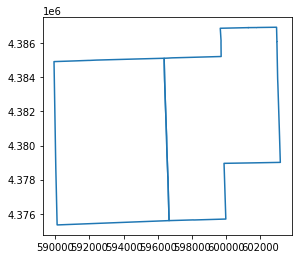

In [82]:
import matplotlib.pyplot as plt
jurisdiction.exterior.plot()


The shape is right... But, to be sure we need some more landmarks...like maybe roads...

An astonishing amount of road data is available from https://maps.indiana.edu/layerGallery.html?category=Streets.

...so much so that we should just load the data within a reasonable distance around our target jurisdiction:

In [83]:
map_area = jurisdiction.dissolve().envelope.scale(2.5,2.5)
roads = gpd.read_file(
r'Streets_Roads_INDOT_2015/Roads_2015_INDOT_IN.shp',
bbox = map_area,
)
roads = roads.clip(map_area)
roads.head()


,ROUTE_NAME,ALTERNATE_,ALTERNATE1,COUNTY_COD,CITY_CODE,RTEL,RAMP_CODE,SECTION_NO,ROUTE_ID,SHAPE_Leng,JURISDICTI,geometry
1349,None,None,IR 663,73,0000,0663,0000,01,37300000663000001,2034.753564,County Road,"LINESTRING Z (609280.875 4393072.500 0.000, 60..."
1499,N 250 E,None,IR 317,73,0000,0317,0000,01,37300000317000001,1773.037389,County Road,"LINESTRING Z (608426.315 4393340.500 0.000, 60..."
1348,N 500 E,None,IR 661,73,0000,0661,0000,01,37300000661000001,1629.402132,County Road,"LINESTRING Z (612569.890 4393503.890 0.000, 61..."
1497,N 200 E,None,IR 315,73,0000,0315,0000,01,37300000315000001,1498.312892,County Road,"LINESTRING Z (607637.810 4393589.000 0.000, 60..."
1174,COUNTY LINE RD,None,IR 4,30,0000,0004,0000,01,33000000004000001,4861.976726,County Road,"LINESTRING Z (606041.115 4395076.665 0.000, 60..."


OK, those look like road names we know from the area...how about a visualization?

<AxesSubplot:>

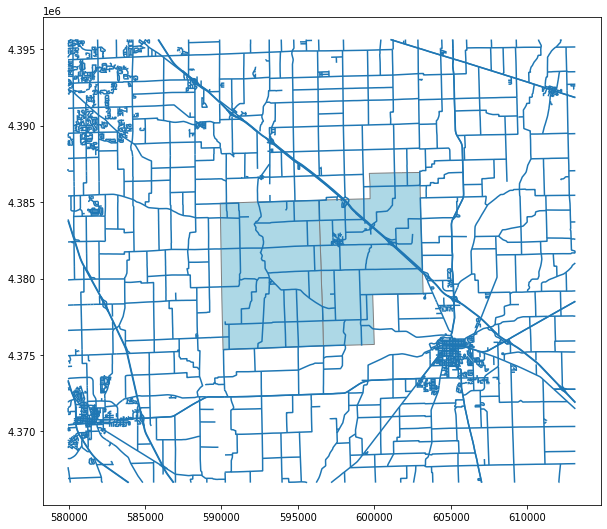

In [84]:
fig, ax = plt.subplots(figsize=(10,10))
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax)

That looks familiar. We can pick out features like Shelbyville, I74, I65, and Fairland. And our two townships look right in comparison to those features.

OK, now we can look back at our data about engines in context...

<AxesSubplot:>

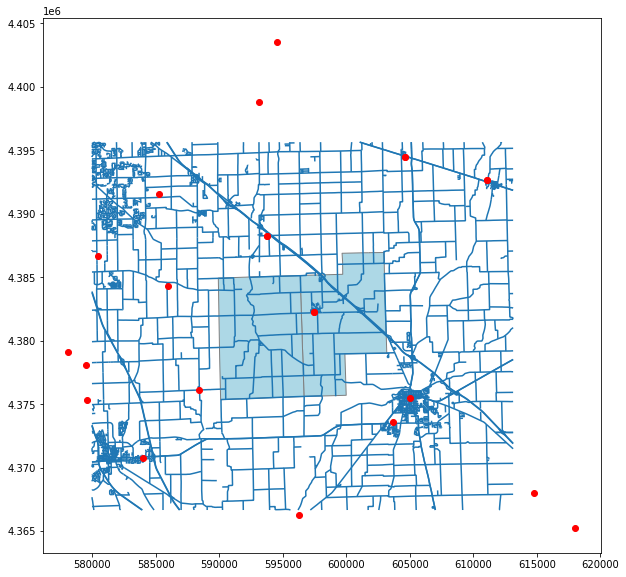

In [126]:
fig, ax = plt.subplots(figsize=(10,10))
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax)
engines.plot(ax=ax, color='red', zorder=5)

Now the magic occurs...

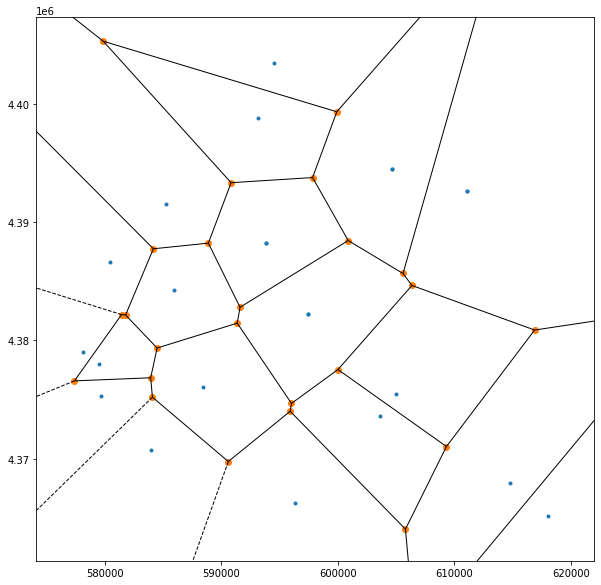

In [123]:
import scipy.spatial
import numpy as np

engine_coords = [(x,y) for x,y in zip(engines['geometry'].x , engines['geometry'].y)]

vor = scipy.spatial.Voronoi(engine_coords)

fig, ax = plt.subplots(figsize=(10,10))
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax=ax)


Now, let's plot it all on one map:

<AxesSubplot:>

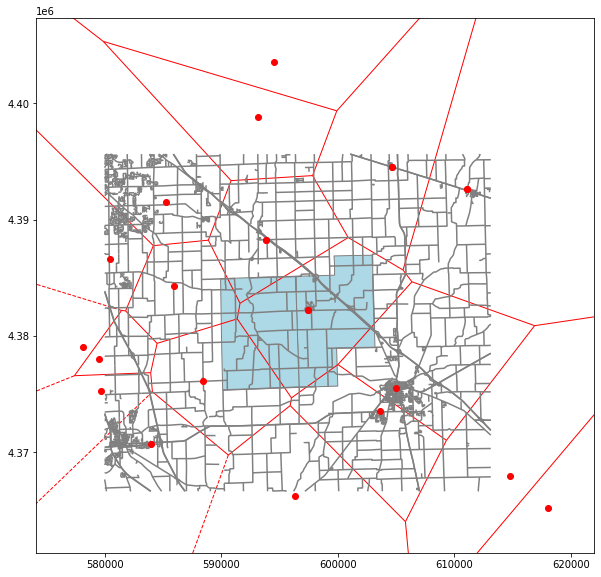

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='red')
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax, color='grey', zorder=5)
engines.plot(ax=ax, color='red', zorder=10)


...and if we focus on "closest non-Fairland engine" by removing Fairland's engines from the list before generating the Voronoi diagram...

<AxesSubplot:>

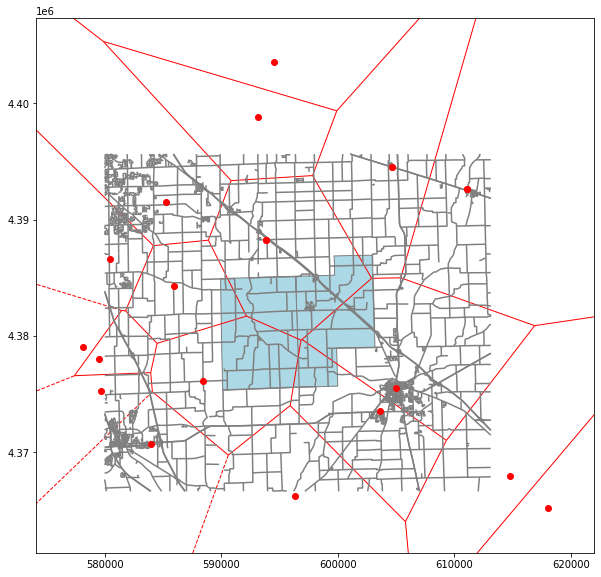

In [125]:
second_due_engines = engines[~engines['name'].str.contains("Fairland")]
second_due_engine_coords = [(x,y) for x,y in zip(second_due_engines['geometry'].x , second_due_engines['geometry'].y)]

vor = scipy.spatial.Voronoi(second_due_engine_coords)

fig, ax = plt.subplots(figsize=(10,10))
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='red')
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax, color='grey', zorder=5)
second_due_engines.plot(ax=ax, color='red', zorder=10)


...and similar for tankers

<AxesSubplot:>

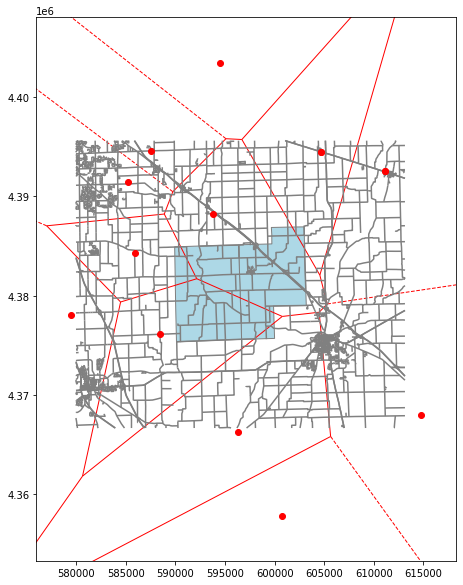

In [131]:
tankers_df = get_tankers()
tankers = gpd.GeoDataFrame(tankers_df, geometry=gpd.points_from_xy(tankers_df.lon, tankers_df.lat), crs='EPSG:4326')
tankers = tankers.to_crs('EPSG:26916')

second_due_tankers = tankers[~tankers['name'].str.contains("Fairland")]
second_due_tanker_coords = [(x,y) for x,y in zip(second_due_tankers['geometry'].x , second_due_tankers['geometry'].y)]

vor = scipy.spatial.Voronoi(second_due_tanker_coords)

fig, ax = plt.subplots(figsize=(10,10))
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='red')
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax, color='grey', zorder=5)
second_due_tankers.plot(ax=ax, color='red', zorder=10)


Now...about that "closest **two** non-Fairland tankers, **not from the same station**" bit...that's technically a second-order Voronoi analysis...for which there is an algorithm that amounts to:
  1. Start with the first-order diagram for the set S
  1. Replace each cell generated by X = {x1, x2, ..., xn−1} with a Voronoi diagram generated on the set S − X
  1. ...do some union/intersection math...
  1. Profit!

<AxesSubplot:>

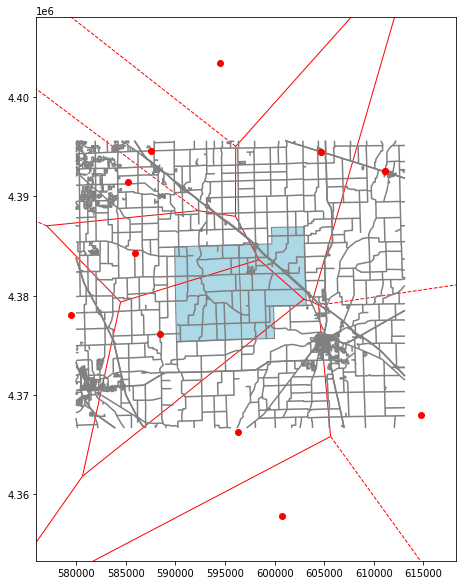

In [137]:
second_due_tankers = tankers[~tankers['name'].str.contains(r"Fairland|Moral")]
second_due_tanker_coords = [(x,y) for x,y in zip(second_due_tankers['geometry'].x , second_due_tankers['geometry'].y)]

vor = scipy.spatial.Voronoi(second_due_tanker_coords)

fig, ax = plt.subplots(figsize=(10,10))
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='red')
jurisdiction.plot(ax=ax, color='lightblue', edgecolor='grey')
roads.plot(ax=ax, color='grey', zorder=5)
second_due_tankers.plot(ax=ax, color='red', zorder=10)
